In [ ]:
import keras.models
import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf
import os
os.environ["KERAS_BACKEND"] = "jax"
from FyeldGenerator import generate_field
import colorcet as cc
from resnet import ResNetSummary

In [ ]:
def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        base = np.power(k, -alpha) * scale**2
        return base

    return power_spectrum


def distribution(shape=(128, 128)):
    a = np.random.normal(loc=0, scale=1., size=shape)
    b = np.random.normal(loc=0, scale=1., size=shape)
    return a + 1j * b

In [4]:
shape = (128, 128)
n_examples = 5
alphas = np.linspace(2, 5, n_examples)
spectra = [generate_power_spectrum(alpha, 1) for alpha in alphas]

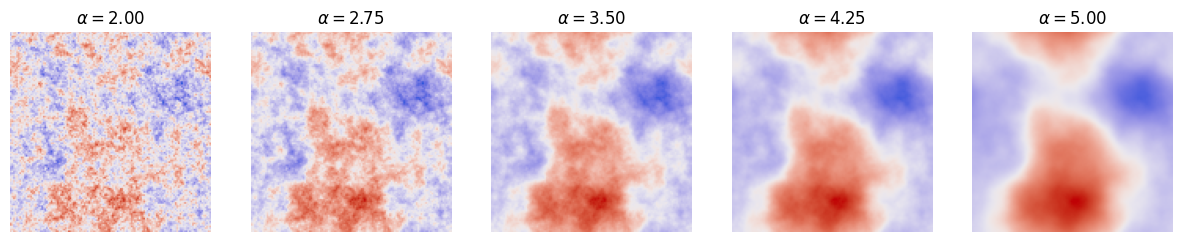

In [9]:
def plot_distribution(shape=(128, 128)):
    rng = np.random.default_rng(seed=42)
    a = rng.normal(loc=0, scale=1., size=shape)
    b = rng.normal(loc=0, scale=1., size=shape)
    return a + 1j * b
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 4))

for power_spectrum, alpha, ax in zip(spectra, alphas, axs):
    field = generate_field(plot_distribution, power_spectrum, shape)
    max_magnitude = np.max(np.abs(field))
    # cc.cm.CET_D1A, cc.cm.coolwarm, "seismic", cc.cm.CET_R3
    ax.imshow(field, cmap=cc.cm.coolwarm, vmin=-max_magnitude, vmax=max_magnitude)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_axis_off()

In [10]:
rng = np.random.default_rng(seed=42)


def prior():
    return {"log_std": rng.normal(scale=0.3), "alpha": rng.normal(loc=3, scale=0.5)}


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None]}


simulator = bf.make_simulator([prior, likelihood])

## Training

In [11]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(500)

In [12]:
summary_network = ResNetSummary(
    summary_dim=8, 
    widths=[16, 32],
    use_batch_norm=False,
    dropout=0.0
)

inference_network = bf.networks.FlowMatching(subnet_kwargs={"widths": 3*(32,), "dropout": 0.0})

workflow = bf.workflows.BasicWorkflow(
    #simulator=simulator,
    summary_network=summary_network,
    inference_network=inference_network,
    inference_variables=["log_std", "alpha"],
    summary_variables=["field"],
    standardize="summary_variables",
)

In [13]:
workflow.approximator.summary()

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching (FlowMatching)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_summary (ResNetSummary) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ standardization                 │ ?                      │   0 (unbuilt) │
│ (Standardization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = workflow.fit_offline(
    data=training_data,
    epochs=100,
    validation_data=validation_data,
    batch_size=32,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 13.7135 - val_loss: 2.2316
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0144 - val_loss: 0.6741
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6483 - val_loss: 0.5466
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5452 - val_loss: 0.4794
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4737 - val_loss: 0.4444
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4419 - val_loss: 0.4054
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4039 - val_loss: 0.4519
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3898 - val_loss: 0.3880
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3516 - val_loss: 0.3889
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3581 - val_loss: 0.3123
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3184 - val_loss: 0.2725
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━

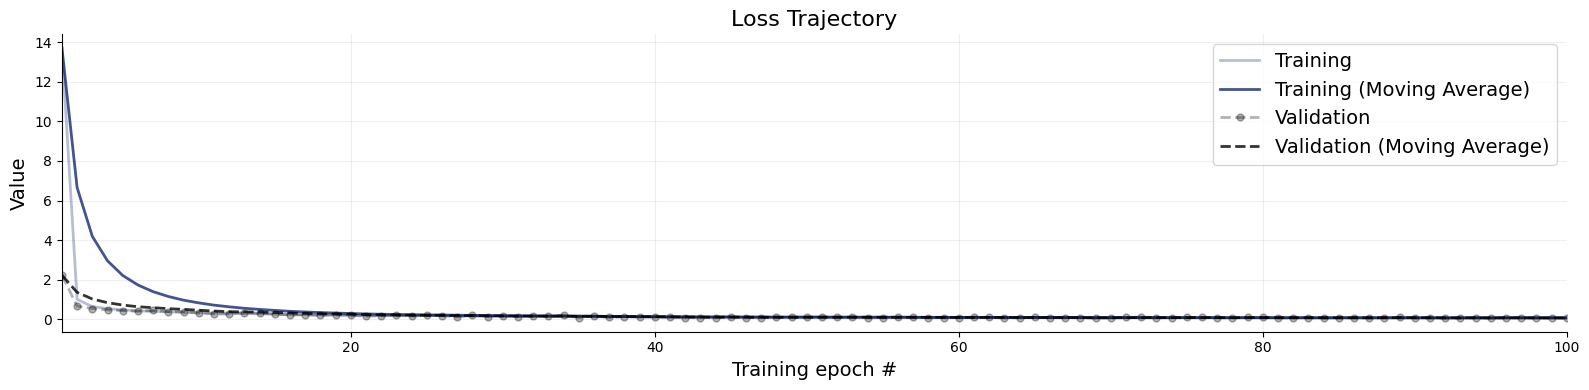

In [15]:
f = bf.diagnostics.plots.loss(history)

W1018 19:19:48.089330   17137 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W1018 19:19:48.268463   17137 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1016.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W1018 19:19:48.272815   17137 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1016.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W1018 19:19:48.321201   17137 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1016.01MiB with freed_by_count=0. The caller indi

{'recovery': <Figure size 1000x500 with 2 Axes>,
 'calibration': <Figure size 1000x500 with 2 Axes>}

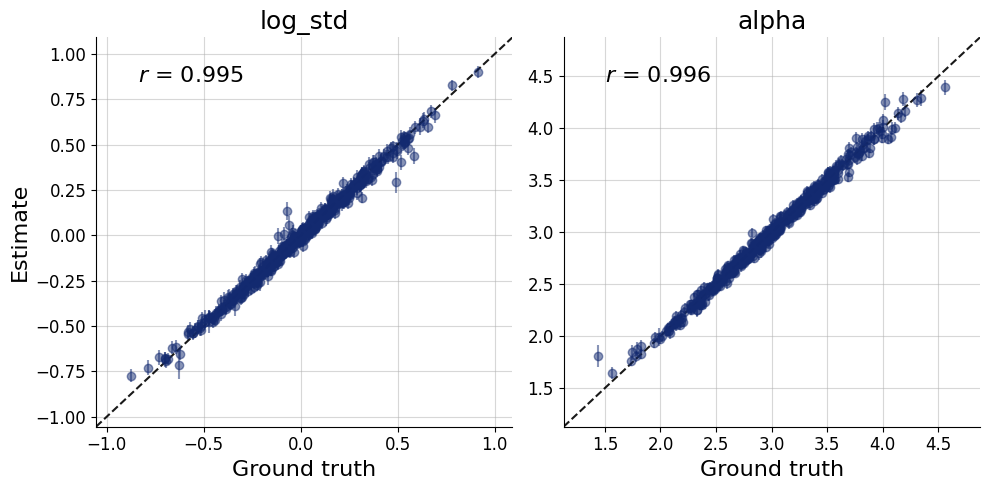

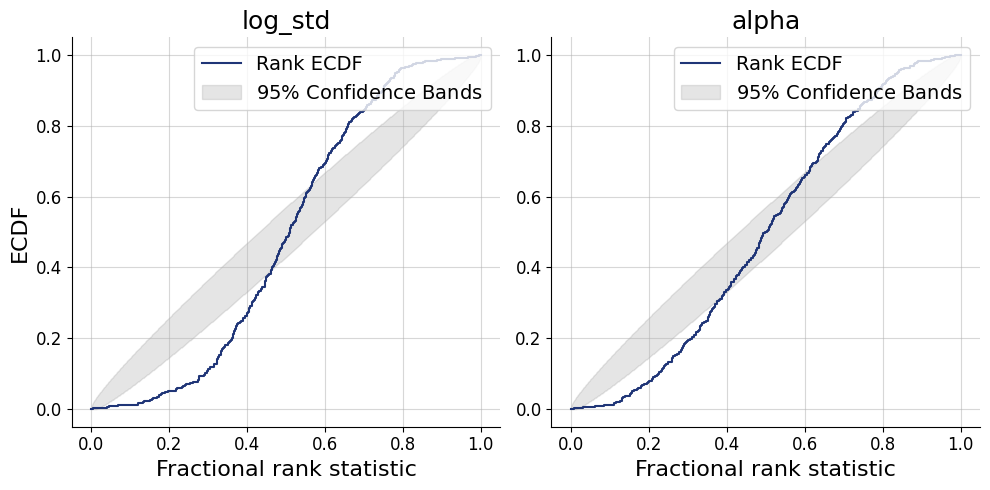

In [16]:
small_training_data = {k: v[:100] for k,v in training_data.items()}
test_data = validation_data
workflow.plot_custom_diagnostics(
    test_data=test_data,
    plot_fns={
        "recovery": bf.diagnostics.recovery,
        "calibration": bf.diagnostics.calibration_ecdf,
    },
)

In [17]:
workflow.approximator.summary()

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching (FlowMatching)    │ ?                      │         2,562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_summary (ResNetSummary) │ (32, 8)                │        16,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ standardization                 │ ?                      │             3 │
│ (Standardization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,586 (224.95 KB)

 Trainable params: 19,194 (74.98 KB)

 Non-trainable params: 3 (12.00 B)

 Optimizer params: 38,389 (149.96 KB)

# Evaluations

In [1]:
import numpy as np
import bayesflow as bf
import keras
import resnet

Defaulting to JAX.
To override, set the KERAS_BACKEND environment variable before importing bayesflow.
See: https://keras.io/getting_started/#configuring-your-backend
INFO:2025-10-25 19:49:05,616:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/nielsbracher/miniconda3/envs/diffusion-exp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/nielsbracher/miniconda3/envs/diffusion-exp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:bayesflow

In [9]:
checkpoint_path = "flow_matching/NPE/checkpoints/8_shape_config_8_16.keras"
model = keras.saving.load_model(checkpoint_path)
model.summary()

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching (FlowMatching)    │ ?                      │         2,434 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_summary (ResNetSummary) │ (32, 4)                │         1,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ standardization_1               │ ?                      │             3 │
│ (Standardization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,910 (50.43 KB)

 Trainable params: 4,302 (16.80 KB)

 Non-trainable params: 3 (12.00 B)

 Optimizer params: 8,605 (33.61 KB)

In [3]:
models = [
    "consistency_model",
    "diffusion_edm_vp",
    "flow_matching",
]
scales = [2**n for n in range(3, 9)]
target = "NPE"
model_configs = ["8_16", "32_64_128_256"]
checkpoint_paths = [
    f"{model}/{target}/checkpoints/{scale}_shape_config_{scale}.keras"
    for model in models
    for scale in scales
]
print(checkpoint_paths)
numbers_paths = [
    f"{model}/{target}/numbers_{mode}_{scale}_shape_config_{scale}.npz"
    for model in models
    for scale in scales
    for mode in ["train", "validation"]
]
print(numbers_paths)

['consistency_model/NPE/checkpoints/8_shape_config_8.keras', 'consistency_model/NPE/checkpoints/16_shape_config_16.keras', 'consistency_model/NPE/checkpoints/32_shape_config_32.keras', 'consistency_model/NPE/checkpoints/64_shape_config_64.keras', 'consistency_model/NPE/checkpoints/128_shape_config_128.keras', 'consistency_model/NPE/checkpoints/256_shape_config_256.keras', 'diffusion_edm_vp/NPE/checkpoints/8_shape_config_8.keras', 'diffusion_edm_vp/NPE/checkpoints/16_shape_config_16.keras', 'diffusion_edm_vp/NPE/checkpoints/32_shape_config_32.keras', 'diffusion_edm_vp/NPE/checkpoints/64_shape_config_64.keras', 'diffusion_edm_vp/NPE/checkpoints/128_shape_config_128.keras', 'diffusion_edm_vp/NPE/checkpoints/256_shape_config_256.keras', 'flow_matching/NPE/checkpoints/8_shape_config_8.keras', 'flow_matching/NPE/checkpoints/16_shape_config_16.keras', 'flow_matching/NPE/checkpoints/32_shape_config_32.keras', 'flow_matching/NPE/checkpoints/64_shape_config_64.keras', 'flow_matching/NPE/checkpoi

In [19]:
z = np.load(numbers_paths[0], allow_pickle=True)
for k, v in z.items():
    print(k, v)

nrmse_values [0.14434781 0.14386538]
nrmse_names ['log_std' 'alpha']
nrmse_metric_name NRMSE
ce_values [0.10384211 0.07336842]
ce_names ['log_std' 'alpha']
ce_metric_name Calibration Error
clg_values [-13.74542606 -11.58614979]
clg_names ['log_std' 'alpha']
clg_metric_name Log Gamma


In [4]:
import os, re
import pandas as pd

# numbers_paths = [...]  # your list from above
_rx = re.compile(r"numbers_(train|validation)_(\d+)_", re.IGNORECASE)

def parse_model_mode_scale(p: str):
    model = p.split("/", 1)[0]
    m = _rx.search(os.path.basename(p))
    if not m:
        raise ValueError(f"Could not parse mode/scale from {p}")
    mode = m.group(1).lower()
    scale = int(m.group(2))
    return model, mode, scale

def row_from_npz(p):
    z = np.load(p, allow_pickle=True)
    model, mode, scale = parse_model_mode_scale(p)
    row = {"model": model, "mode": mode, "scale": scale}
    # collect metrics for both variables by name (alpha, log_std)
    for metric in ("nrmse", "ce", "clg"):
        vals = z[f"{metric}_values"]
        names = z[f"{metric}_names"]
        for name, val in zip(names.tolist(), vals.tolist()):
            row[f"{metric}_{name}"] = float(val)
    return row

rows = [row_from_npz(p) for p in numbers_paths]
df = pd.DataFrame(rows)


# optional: rename clg_* -> log_gamma_* for readability
df = df.rename(columns=lambda c: c.replace("clg_", "log_gamma_"))

wanted_cols = [
    "model", "mode", "scale",
    "nrmse_alpha", "nrmse_log_std",
    "ce_alpha", "ce_log_std",
    "log_gamma_alpha", "log_gamma_log_std",
]
# Some files may miss a metric → fill missing columns with NaN
for c in wanted_cols:
    if c not in df.columns:
        df[c] = np.nan

# 4) nice sort (Train first, then Validation, by scale)
mode_order = {"train": 0, "validation": 1}
df["_mode_order"] = df["mode"].map(mode_order).fillna(99)
df = (df[wanted_cols]
      .assign(_mode_order=df["_mode_order"])
      .sort_values(["model", "_mode_order", "scale"])
      .drop(columns="_mode_order")
      .reset_index(drop=True))

print(df)

                model        mode  scale  nrmse_alpha  nrmse_log_std  \
0   consistency_model       train      8     0.130927       0.135780   
1   consistency_model       train     16     0.088225       0.094155   
2   consistency_model       train     32     0.038411       0.043564   
3   consistency_model       train     64     0.020802       0.023990   
4   consistency_model       train    128     0.010818       0.012336   
5   consistency_model       train    256     0.008767       0.011771   
6   consistency_model  validation      8     0.152310       0.155937   
7   consistency_model  validation     16     0.104247       0.100406   
8   consistency_model  validation     32     0.041376       0.045997   
9   consistency_model  validation     64     0.020823       0.029229   
10  consistency_model  validation    128     0.012044       0.011419   
11  consistency_model  validation    256     0.008421       0.011847   
12   diffusion_edm_vp       train      8     0.131600       0.13

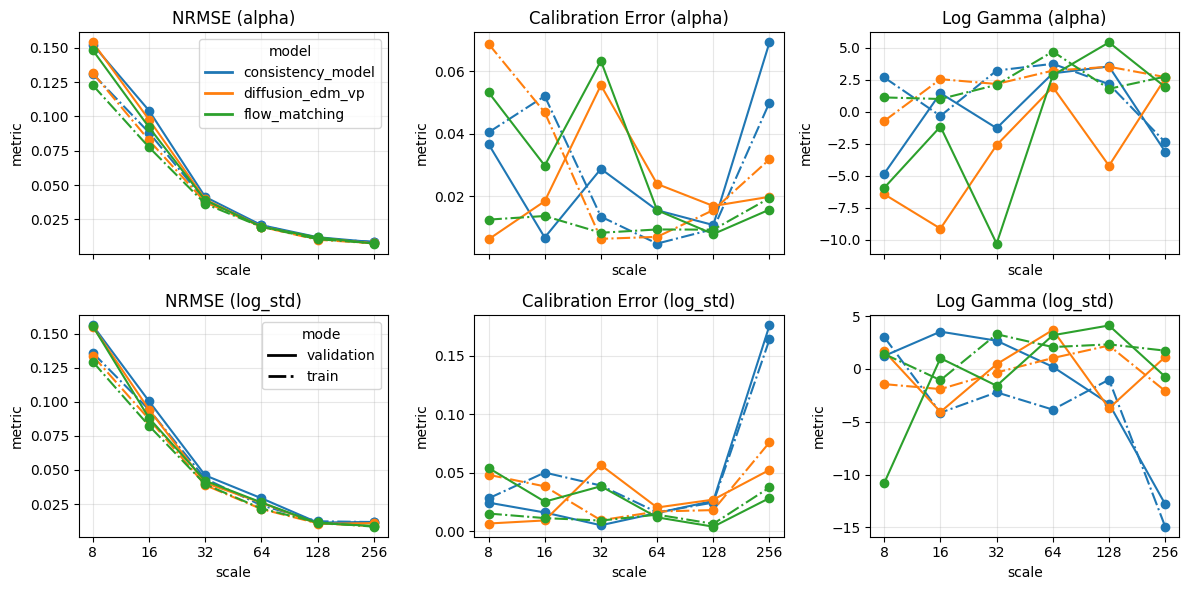

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# df columns: model, mode, scale,
#   nrmse_alpha, nrmse_log_std, ce_alpha, ce_log_std, log_gamma_alpha, log_gamma_log_std

# equally spaced x positions, tick labels are the actual scales
scales = sorted(df["scale"].unique())
pos = np.arange(len(scales))  # 0..n-1 equally spaced

# consistent color per model
models = list(sorted(df["model"].unique()))
cycle_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3"])
color_map = {m: cycle_colors[i % len(cycle_colors)] for i, m in enumerate(models)}

# linestyle per mode
style_map = {"train": "-.", "validation": "-"}

def plot_metric(ax, col, title):
    for m in models:
        for md in ("validation", "train"):  # order so solid lines (validation) draw first
            sub = (
                df[(df["model"] == m) & (df["mode"] == md)]
                .set_index("scale")
                .reindex(scales)      # align to all scales
                .sort_index()
            )
            ax.plot(
                pos, sub[col].values,
                marker="o",
                linestyle=style_map.get(md, "-"),
                color=color_map[m],
                label=f"{m} ({md})"
            )
    ax.set_title(title)
    ax.set_xlabel("scale")
    ax.set_ylabel("metric")
    ax.set_xticks(pos)
    ax.set_xticklabels([str(s) for s in scales])
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

# top row: alpha
plot_metric(axes[0, 0], "nrmse_alpha",       "NRMSE (alpha)")
plot_metric(axes[0, 1], "ce_alpha",          "Calibration Error (alpha)")
plot_metric(axes[0, 2], "log_gamma_alpha",   "Log Gamma (alpha)")

# bottom row: log_std
plot_metric(axes[1, 0], "nrmse_log_std",     "NRMSE (log_std)")
plot_metric(axes[1, 1], "ce_log_std",        "Calibration Error (log_std)")
plot_metric(axes[1, 2], "log_gamma_log_std", "Log Gamma (log_std)")

# legends: one for models (colors), one for modes (linestyles)
model_handles = [Line2D([0], [0], color=color_map[m], lw=2, label=m) for m in models]
mode_handles  = [Line2D([0], [0], color="black", lw=2, linestyle=style_map[k], label=k)
                 for k in ("validation", "train")]

axes[0, 0].legend(handles=model_handles, title="model", loc="best")
axes[1, 0].legend(handles=mode_handles,  title="mode",  loc="best")

plt.tight_layout()
plt.show()
